# Visualization and examplary class detection for Audiofiles

In [ ]:
# import important libraries
import librosa
import numpy as np
import matplotlib.pyplot as pl
import IPython.display as ipd
import random
import zipfile
import os
import glob
import torch
from IPython.display import display

Audiodata is extracted from a folder "test_files", which can either be provided as a .zip-file "test_files.zip", which is extracted into folder "test_files", or directly in that folder. Audiodata must be provided as ".wav"-files, which are added to the array "audio_input for further use.

In [ ]:
# load .wav-files as input and play it
# first: add the "test-files"-directory to the sample_data of the notebook, or change the path to lead to it in your configuration

# if there is a zip-file containi, unzip it:
if os.path.isfile('test_files.zip'):
  with zipfile.ZipFile('WakeWordDetection-visualization/visualization/test_files.zip', 'r') as zip:
    zip.extractall('.')

# else if there is no directory with the same name
elif not(os.path.isdir('WakeWordDetection-visualization/visualization/test_files')):
  print('No directory "test_files" detected, make sure to add the zipped directory it to "sample data" first!')

else:
  audio_input = []#todo
  files = sorted(glob.glob(os.path.join('test_files', '*.wav'))) #get all the .wav-files in test_files
  for i in files:
    audio_input.append(i)
    print(i)



test_files/test0.wav.wav
test_files/test1.wav.wav
test_files/test2.wav.wav
test_files/test3.wav.wav
test_files/test4.wav.wav
test_files/test5.wav.wav
test_files/test6.wav.wav
test_files/test7.wav.wav
test_files/test8.wav.wav


To later visualize the individual audiofiles as spectograms, we use the function compute_mel_spec_for_audio_file defined in CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, provided by Prof. Dr. Jakob Abeßer. 

In [20]:
# define function for visualizing spectogram for audio file
# definition from CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, author: Prof. Dr. Jakob Abeßer

def compute_mel_spec_for_audio_file(fn_wav, #dataset
                                    n_fft=1024,
                                    hop_length=441,
                                    fs=22050.,
                                    n_mels=64):
    """ Compute mel spectrogram
    Args:
        fn_wav (str): Audio file name
        n_fft (int): FFT size
        hop_length (int): Hop size in samples
        fs (float): Sample rate in Hz
        n_mels (int): Number of mel bands
    """
    # load audio samples
    x, fs = librosa.load(fn_wav, sr=fs, mono=True)

    # normalize to the audio file to an maximum absolute value of 1
    if np.max(np.abs(x)) > 0:
        x = x / np.max(np.abs(x))

    # mel-spectrogram
    X = librosa.feature.melspectrogram(y=x,
                                       sr=fs,
                                       n_fft=n_fft,
                                       hop_length=hop_length,
                                       n_mels=n_mels,
                                       fmin=0.0,
                                       fmax=fs / 2,
                                       power=1.0,
                                       htk=True,
                                       norm=None)

    # apply dB normalization, empthasize parts of the noise with low decibels, equalizes Lautstärke
    X = librosa.amplitude_to_db(X)

    return X

For ease o use, we further define function display_plotted_spectogram, which prints the spectogram as a plot, containing code from the same notebook CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, provided by Prof. Dr. Jakob Abeßer 

In [ ]:
#Define function to disply a spectogram as a plot
def display_plotted_spectogram(input_file):
  # code from CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, author: Prof. Dr. Jakob Abeßer

  mel_spec = compute_mel_spec_for_audio_file(input_file)
  print("\n\nShape of Mel-spectrogram for audiofile", input_file, ":", mel_spec.shape) # to compare shape of spectogram against expectation

  pl.figure()
  pl.imshow(mel_spec, origin="lower", aspect="auto", interpolation="None")#origin: where is 0:0 in coordinate system?
  pl.ylabel('Mel frequency bands')
  pl.xlabel('Time frames')
  pl.show()
  #black in the spectogram is silence; zero-padding to achieve sequences of equal length

The next codeblock provides a player for an audiofile (again using code from CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, author: Prof. Dr. Jakob Abeßer) as well as visualiation as a spectogram.
Through changing the value of the variable file_amount, the user can decide how many of the files should be visualized (and for how many the model shall make predictions later). With value "1", a random file is chosen, for all higher values the amount of files is chosen in the order present in the audio_input-array. If the number exceeds that of the existing files, we default to simply choosing all existing files.

Would you like to visualize, play and predict the class of only one of the example files or all of them?
Change the value of the variable "file_amount" to determine how many files you would like to choose.



 Play to determine correct class for file test_files/test0.wav.wav :




Shape of Mel-spectrogram for audiofile test_files/test0.wav.wav : (64, 63)


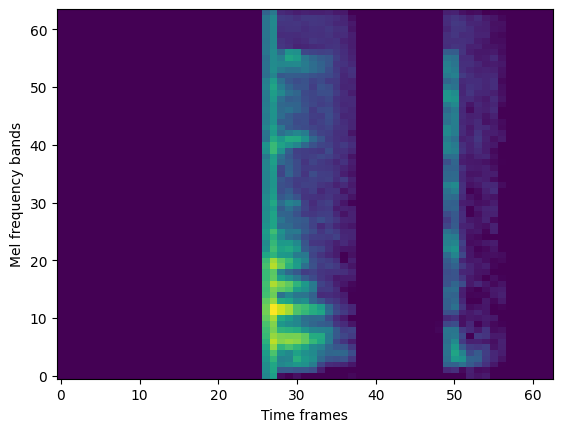



 Play to determine correct class for file test_files/test1.wav.wav :




Shape of Mel-spectrogram for audiofile test_files/test1.wav.wav : (64, 98)


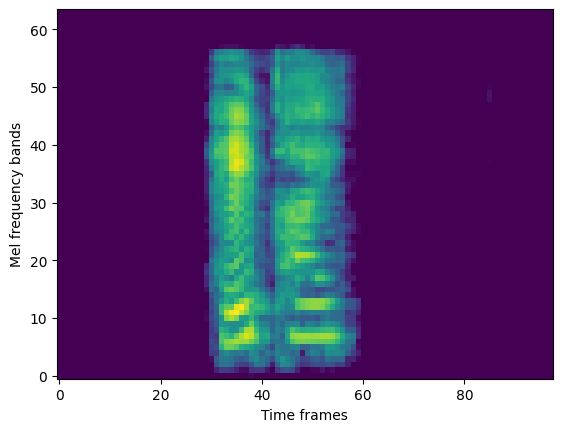

In [ ]:
#Play a sample file and visualize it
print("Would you like to visualize, play and predict the class of only one of the example files or all of them?")

#todo: remove or use
#dropdown = ipywidgets.Dropdown(
#    options=['one random sample', 'all'],
#    description='How many samples would you like to use?',
#    disabled=False,
#)
#display(dropdown)

#choice = dropdown.value
#print(choice)
print('Change the value of the variable "file_amount" to determine how many files you would like to choose.\n')

# set file_ amount to 1 to display one random sample, custom number to display a number od your choosing or len(audio.input)-1 to display all example files
file_amount = 2
#select random example now to keep it the same
example_index = random.randint(0,len(audio_input)-1) #choose random index in dataset range
example_input = audio_input[example_index] #choose file at the random index as example

if file_amount == 0:
  print('Please choose the amount of files to visualize - your choice of "0" files does not work.')

elif file_amount == 1:
  example_index = random.randint(0,len(audio_input)-1) #choose random index in dataset range
  example_input = audio_input[example_index] #choose file at the random index as example

  print("Play the example file to determine correct class for file " + example_input +" :")
  # code from CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, author: Prof. Dr. Jakob Abeßer
  x, fs = librosa.load(example_input)
  ipd.display(ipd.Audio(data=x, rate=fs)) #visualizes a player for the input file

  # visualize the input file as a spectogram
  display_plotted_spectogram(example_input)

else:
  if file_amount >= len(audio_input)-1:
    file_amount = len(audio_input)-1
    print('There are less files than you wanted to select, all available files will be displayed instead. Available files: ' + str(file_amount))

  i = 0
  while i <= file_amount-1:
    audiofile = audio_input[i]
    print('\n\n Play to determine correct class for file ' + audiofile + ' :')
    # code from CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, author: Prof. Dr. Jakob Abeßer
    x, fs = librosa.load(audiofile)
    ipd.display(ipd.Audio(data=x, rate=fs)) #visualizes a player for the input file
    display_plotted_spectogram(audiofile)
    i += 1

To predict the class of the example audio-files, we first load one of the different models ('cnn': WakeWordCNN,'crnn': CRNN_with_MBConv,'crnn_temporal': CRNN_TemporalConv) and load trained weights by choosing a trained state from "trained_models". You can change the used model by changing the value of "model_name" to either "cnn", "crnn" or "crnn_temporal", and the pre-traines weights used by changing the path in "model.load_state_dict".

In [ ]:
# load trained model
from model.model_registry import get_model
from utils.data_loader import load_config

#todo: load correct model
#model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
cfg = load_config()

# Get model architecture from config
model_name = cfg.get('MODEL', 'cnn') #change type of model here!
model = get_model(model_name, input_shape, 2).to(device)#2 = number of classes
print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

#Change path here to try the model with different pre-trained weights!
model.load_state_dict(torch.load('WakeWordDetection-visualization/trained_models/worst_crnn_with_mbconv_model.pth', weights_only=True))
model.eval() #put the model into evaluation mode

#give a model summary
model.summary()

Predict the class of the chosen example-file(s) and print it.

In [ ]:
# predict class wakeword/ non-wakeword for input-files
class_predictions = []

if file_amount == 1:
  class_predictions.append(model.predict(example_input))
  # output prediction and relevant stats
  print("The prediction for the example-file:",example_input, "is: ", class_predictions[example_index])

else:
  i = 0
  while i <= file_amount-1:
    prediction = model.predict(audio_input[i])
    class_predictions.append(prediction)
    print("The prediction for file:",audio_input[i], "is: ", prediction)
    i += 1
